In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import random
from scipy.special import logit, expit 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import statsmodels.api as sm

# Set a fixed random seed for reproducibility
random.seed(19)

df = pd.read_csv("../data/data_final.csv.gz")
df['date'] = pd.to_datetime(df['date'])
to_pred_df = df.loc[df['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
df = df.loc[df['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

In [ ]:

tiles = df['tile_index'].unique().tolist()
random.shuffle(tiles)

train_ratio = 0.75
split_index = int(train_ratio * len(tiles))
train_tiles = tiles[:split_index] 
test_tiles = tiles[split_index:]  

train_df = df.loc[df['tile_index'].isin(train_tiles)]
test_df = df.loc[df['tile_index'].isin(test_tiles)]

X_cols = [col for col in df.columns if col.startswith('feature')]
y_col = 'avg_urban_imperviousness'

def logit_fun(y, scaler=1.0, epsilon=0.0):
    """
    Apply logit transformation with scaling and epsilon adjustment.
    
    Parameters:
    - y: array-like, target values to be transformed
    - scaler: float, scaling factor to apply before transformation (e.g., 1/100 to convert percentages to proportions)
    - epsilon: float, small adjustment to avoid 0 and 1 boundaries
    
    Returns:
    - y_transformed: transformed target values
    """
    # Scale y and apply epsilon adjustment
    y_adjusted = (y * scaler) * (1 - 2 * epsilon) + epsilon
    # Apply logit transformation
    y_transformed = logit(y_adjusted)
    return y_transformed

def sigmoid_fun(yhat_transformed, scaler=1.0, epsilon=0.0):
    """
    Apply inverse logit (sigmoid) transformation with scaling and epsilon adjustment.
    
    Parameters:
    - yhat_transformed: array-like, transformed predictions to be converted back
    - scaler: float, scaling factor to apply after transformation (e.g., 100 to convert proportions back to percentages)
    - epsilon: float, small adjustment to undo epsilon applied during logit transformation
    
    Returns:
    - yhat: predictions transformed back to the original scale
    """
    # Apply sigmoid transformation
    yhat_adjusted = expit(yhat_transformed)
    # Undo epsilon adjustment and scaling
    yhat = (yhat_adjusted - epsilon) / (1 - 2 * epsilon) / scaler
    return yhat

X_train = train_df[X_cols]
y_train = train_df[y_col]
y_train_transformed = y_train.apply(lambda y: logit_fun(y, 1/100, 10e-6))

X_test = test_df[X_cols]
y_test = test_df[y_col]
y_test_transformed = y_test.apply(lambda y: logit_fun(y, 1/100, 10e-6))

# To undo: apply(lambda y: sigmoid_fun(y, 1/100, 10e-6))

In [7]:
X_train.shape

(13395, 768)

In [135]:
print("Original target distribution:")
print(y_train)
print("\nTransformed target distribution (to ensure final output is 0% <= yhat <= 100%):")
print(y_train_transformed.describe())

Original target distribution:
3        1.442134
4        1.442134
5        1.442134
12       1.512917
13       1.512917
           ...   
17857    0.088217
17858    0.088217
17859    1.061962
17860    1.061962
17861    1.061962
Name: avg_urban_imperviousness, Length: 13395, dtype: float64

Transformed target distribution (to ensure final output is 0% <= yhat <= 100%):
count    13395.000000
mean        -5.096951
std          2.818422
min        -11.512915
25%         -5.621012
50%         -4.282166
75%         -3.398483
max          0.390540
Name: avg_urban_imperviousness, dtype: float64


**Training Data Context**:

  - The mean value of the target variable, `avg_urban_imperviousness`, is approximately 3.21, with a relatively 
    high standard deviation of 5.79.
  -  The data distribution is skewed, with the 75th percentile at 3.23 and a maximum value of 59.64. This suggests 
    that while most values are concentrated at the lower end, there are significant outliers with high imperviousness.

In [ ]:
# Create the directory path for storing the models
models_dir = "../artifacts/models"
os.makedirs(models_dir, exist_ok=True)

In [136]:
# Establish a baseline model using the mean (no transformations needed here)
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=np.float64)

# Calculate baseline performance
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Baseline R^2: {baseline_r2:.4f}")

Baseline RMSE: 5.8842
Baseline R^2: -0.0000


In [138]:
# Simple Linear Regression
lr_model_path = os.path.join(models_dir, 'linear_regression.pkl')
if not os.path.exists(lr_model_path):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train_transformed)
    with open(lr_model_path, 'wb') as f:
        pickle.dump(lr_model, f)
else:
    with open(lr_model_path, 'rb') as f:
        lr_model = pickle.load(f)
lr_pred_transformed = lr_model.predict(X_test)

# Transform predictions back to the original scale using sigmoid_fun
lr_pred = sigmoid_fun(lr_pred_transformed, scaler=1/100, epsilon=10e-6)

# Evaluate Linear Regression model
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)
print(f"Linear Regression RMSE: {lr_rmse:.4f}")
print(f"Linear Regression R^2: {lr_r2:.4f}")

Linear Regression RMSE: 4.6510
Linear Regression R^2: 0.3752


In [139]:
# PCA
pca_95n_path = os.path.join(models_dir, 'pca_95n.pkl')
if not os.path.exists(pca_95n_path):
    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    X_train_pca = pca.fit_transform(X_train)
    with open(pca_95n_path, 'wb') as f:
        pickle.dump(pca, f)
else:
    with open(pca_95n_path, 'rb') as f:
        pca = pickle.load(f)
        X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [141]:
# PCA + Linear Regression
lr_pca_model_path = os.path.join(models_dir, 'pca_linear_regression.pkl')
if not os.path.exists(lr_pca_model_path):
    lr_pca_model = LinearRegression()
    lr_pca_model.fit(X_train_pca, y_train_transformed)
    with open(lr_pca_model_path, 'wb') as f:
        pickle.dump(lr_pca_model, f)
else:
    with open(lr_pca_model_path, 'rb') as f:
        lr_pca_model = pickle.load(f)
lr_pca_pred_transformed = lr_pca_model.predict(X_test_pca)

# Transform predictions back to the original scale using sigmoid_fun
lr_pca_pred = sigmoid_fun(lr_pca_pred_transformed, scaler=1/100, epsilon=10e-6)

# Evaluate PCA + Linear Regression model
lr_pca_rmse = np.sqrt(mean_squared_error(y_test, lr_pca_pred))
lr_pca_r2 = r2_score(y_test, lr_pca_pred)
print(f"PCA + Linear Regression RMSE: {lr_pca_rmse:.4f}")
print(f"PCA + Linear Regression R^2: {lr_pca_r2:.4f}")

PCA + Linear Regression RMSE: 4.5069
PCA + Linear Regression R^2: 0.4133


In [142]:
# LASSO Regression with Cross-Validation
lasso_model_path = os.path.join(models_dir, 'lasso_regression.pkl')
if not os.path.exists(lasso_model_path):
    lasso_model = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5)
    lasso_model.fit(X_train, y_train_transformed)
    with open(lasso_model_path, 'wb') as f:
        pickle.dump(lasso_model, f)
else:
    with open(lasso_model_path, 'rb') as f:
        lasso_model = pickle.load(f)
lasso_pred_transformed = lasso_model.predict(X_test)

# Transform predictions back to the original scale using sigmoid_fun
lasso_pred = sigmoid_fun(lasso_pred_transformed, scaler=1/100, epsilon=10e-6)

# Evaluate LASSO model
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_r2 = r2_score(y_test, lasso_pred)
print(f"LASSO Regression RMSE: {lasso_rmse:.4f}")
print(f"LASSO Regression R^2: {lasso_r2:.4f}")
print(f"Optimal alpha for LASSO: {lasso_model.alpha_:.4e}")

c:\Users\btripp\urban-clay\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.33237589057535, tolerance: 8.384362168584452
  model = cd_fast.enet_coordinate_descent_gram(


LASSO Regression RMSE: 4.2693
LASSO Regression R^2: 0.4736
Optimal alpha for LASSO: 3.7276e-04


c:\Users\btripp\urban-clay\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+01, tolerance: 1.064e+01
  model = cd_fast.enet_coordinate_descent(


In [143]:

# LightGBM with Cross-Validation for Hyperparameter Tuning
lgb_model_path = os.path.join(models_dir, 'lightgbm.pkl')
if not os.path.exists(lgb_model_path):
    lgb_model = LGBMRegressor(random_state=19)

    lgb_param_grid = {
        'num_leaves': [18],
        'learning_rate': [0.05],
        'n_estimators': [1000] 
        # 'reg_alpha': [0.0, 0.1, 0.5, 1.0],        # default: 0.
        # 'reg_lambda': [0.0, 0.1, 0.5, 1.0],       # default: 0.
        # 'min_child_samples': [3, 5, 10, 20, 30],  # default: 20 
        # 'subsample': [0.3, 0.6, 0.8, 1.0],        # default: 1.
        # 'subsample_freq': [-1, 0, 1, 5],          # default: 0.
        # 'colsample_bytree': [0.6, 0.8, 1.0]       # default: 1.
    }

    lgb_cv = GridSearchCV(lgb_model, lgb_param_grid, cv=5, n_jobs=4, scoring='neg_mean_squared_error')
    lgb_cv.fit(X_train, y_train_transformed.values.ravel())
    lgb_best = lgb_cv.best_estimator_
    with open(lgb_model_path, 'wb') as f:
        pickle.dump(lgb_best, f)
else:
    with open(lgb_model_path, 'rb') as f:
        lgb_best = pickle.load(f)
lgb_pred_transformed = lgb_best.predict(X_test)

# Transform predictions back to the original scale using sigmoid_fun
lgb_pred = sigmoid_fun(lgb_pred_transformed, scaler=1/100, epsilon=10e-6)

# Evaluate LightGBM model
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)
print(f"LightGBM RMSE: {lgb_rmse:.4f}")
print(f"LightGBM R^2: {lgb_r2:.4f}")
print(f"Best params for LightGBM: {lgb_cv.best_params_}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13395, number of used features: 768
[LightGBM] [Info] Start training from score -5.096951
LightGBM RMSE: 3.2464
LightGBM R^2: 0.6956
Best params for LightGBM: {'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 18}


                     Model      RMSE       R^2
0                 Baseline  5.884237 -0.000032
1        Linear Regression  4.650998  0.375222
2  PCA + Linear Regression  4.506920  0.413331
3         LASSO Regression  4.269319  0.473558
4                 LightGBM  3.246434  0.695599


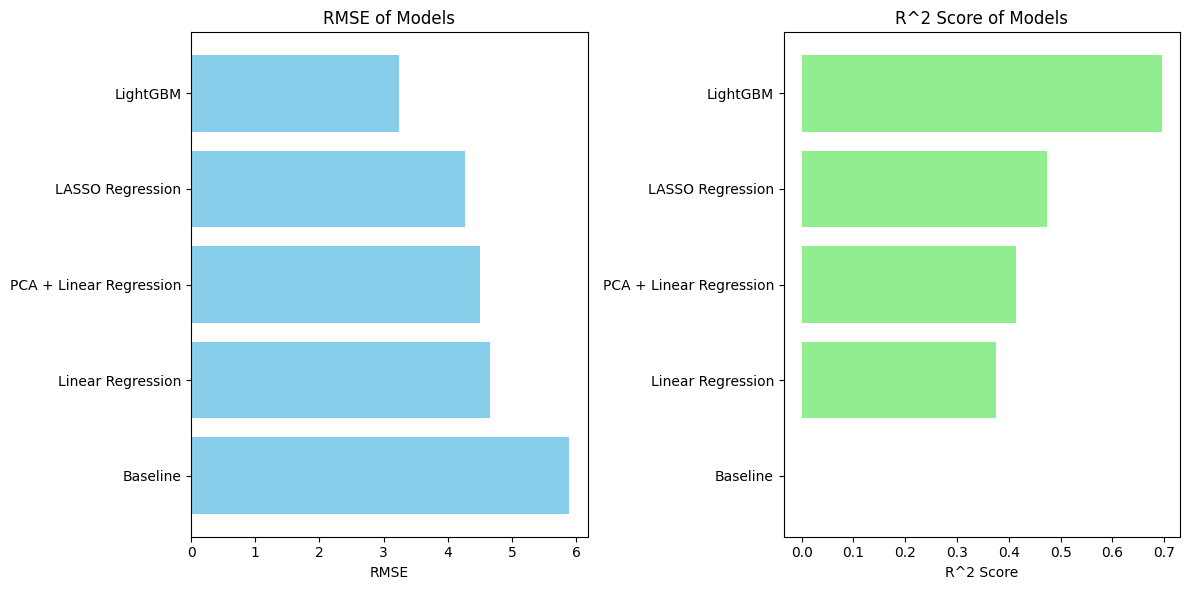

In [144]:
models = {
    'baseline': baseline_pred,  # Note: this is not a model, just predictions; saving for consistency
    'linear_regression': lr_model,
    'pca_linear_regression': lr_pca_model,
    'lasso_regression': lasso_model,
    'lightgbm': lgb_best
}

# Create a dictionary to store the model results
results = {
    'Model': ['Baseline', 'Linear Regression', 'PCA + Linear Regression', 'LASSO Regression', 'LightGBM'],
    'RMSE': [baseline_rmse, lr_rmse, lr_pca_rmse, lasso_rmse, lgb_rmse],
    'R^2': [baseline_r2, lr_r2, lr_pca_r2, lasso_r2, lgb_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

# Plot the scores for easy comparison
plt.figure(figsize=(12, 6))

# RMSE Plot
plt.subplot(1, 2, 1)
plt.barh(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.xlabel('RMSE')
plt.title('RMSE of Models')

# R^2 Plot
plt.subplot(1, 2, 2)
plt.barh(results_df['Model'], results_df['R^2'], color='lightgreen')
plt.xlabel('R^2 Score')
plt.title('R^2 Score of Models')

plt.tight_layout()
plt.show()

In [147]:
def smape(y_actual, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_actual) / (np.abs(y_actual) + np.abs(y_pred)))

def plot_predictions_vs_actuals(y_actual, y_pred, title="Predictions vs Actuals", fig_size=(8, 8), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    ax.scatter(y_actual, y_pred, alpha=0.6)
    ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)  # Line y=x
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_residuals(y_actual, y_pred, title="Residual Plot", fig_size=(10, 6), ax=None):
    residuals = y_actual - y_pred
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    ax.scatter(y_pred, residuals, alpha=0.6)
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_residual_histogram(y_actual, y_pred, bins=30, title="Histogram of Residuals", fig_size=(10, 6), ax=None):
    residuals = y_actual - y_pred
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    sns.histplot(residuals, kde=True, bins=bins, color='blue', alpha=0.7, ax=ax)
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    return ax

def plot_cdf_of_absolute_errors(y_actual, y_pred, title="CDF of Absolute Errors", fig_size=(10, 6), ax=None):
    abs_errors = np.abs(y_actual - y_pred)
    sorted_errors = np.sort(abs_errors)
    cumulative_distribution = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(sorted_errors, cumulative_distribution, marker='.', linestyle='-', color='blue')
    ax.set_xlabel("Absolute Error")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_qq_plot(y_actual, y_pred, title="Q-Q Plot of Residuals", fig_size=(8, 8), ax=None):
    residuals = y_actual - y_pred
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    sm.qqplot(residuals, line='s', ax=ax)
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_residuals_boxplot(y_actual, y_pred, title="Box Plot of Residuals", fig_size=(10, 6), ax=None):
    residuals = y_actual - y_pred
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(data=residuals, orient='h', ax=ax)
    ax.set_xlabel("Residuals")
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_cooks_distance(X, y, title="Cook's Distance Plot", fig_size=(10, 6), ax=None):
    X_with_const = sm.add_constant(X)  # Add constant for intercept
    model = sm.OLS(y, X_with_const).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    ax.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
    ax.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold Line')
    ax.set_xlabel("Observation Index")
    ax.set_ylabel("Cook's Distance")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    return ax

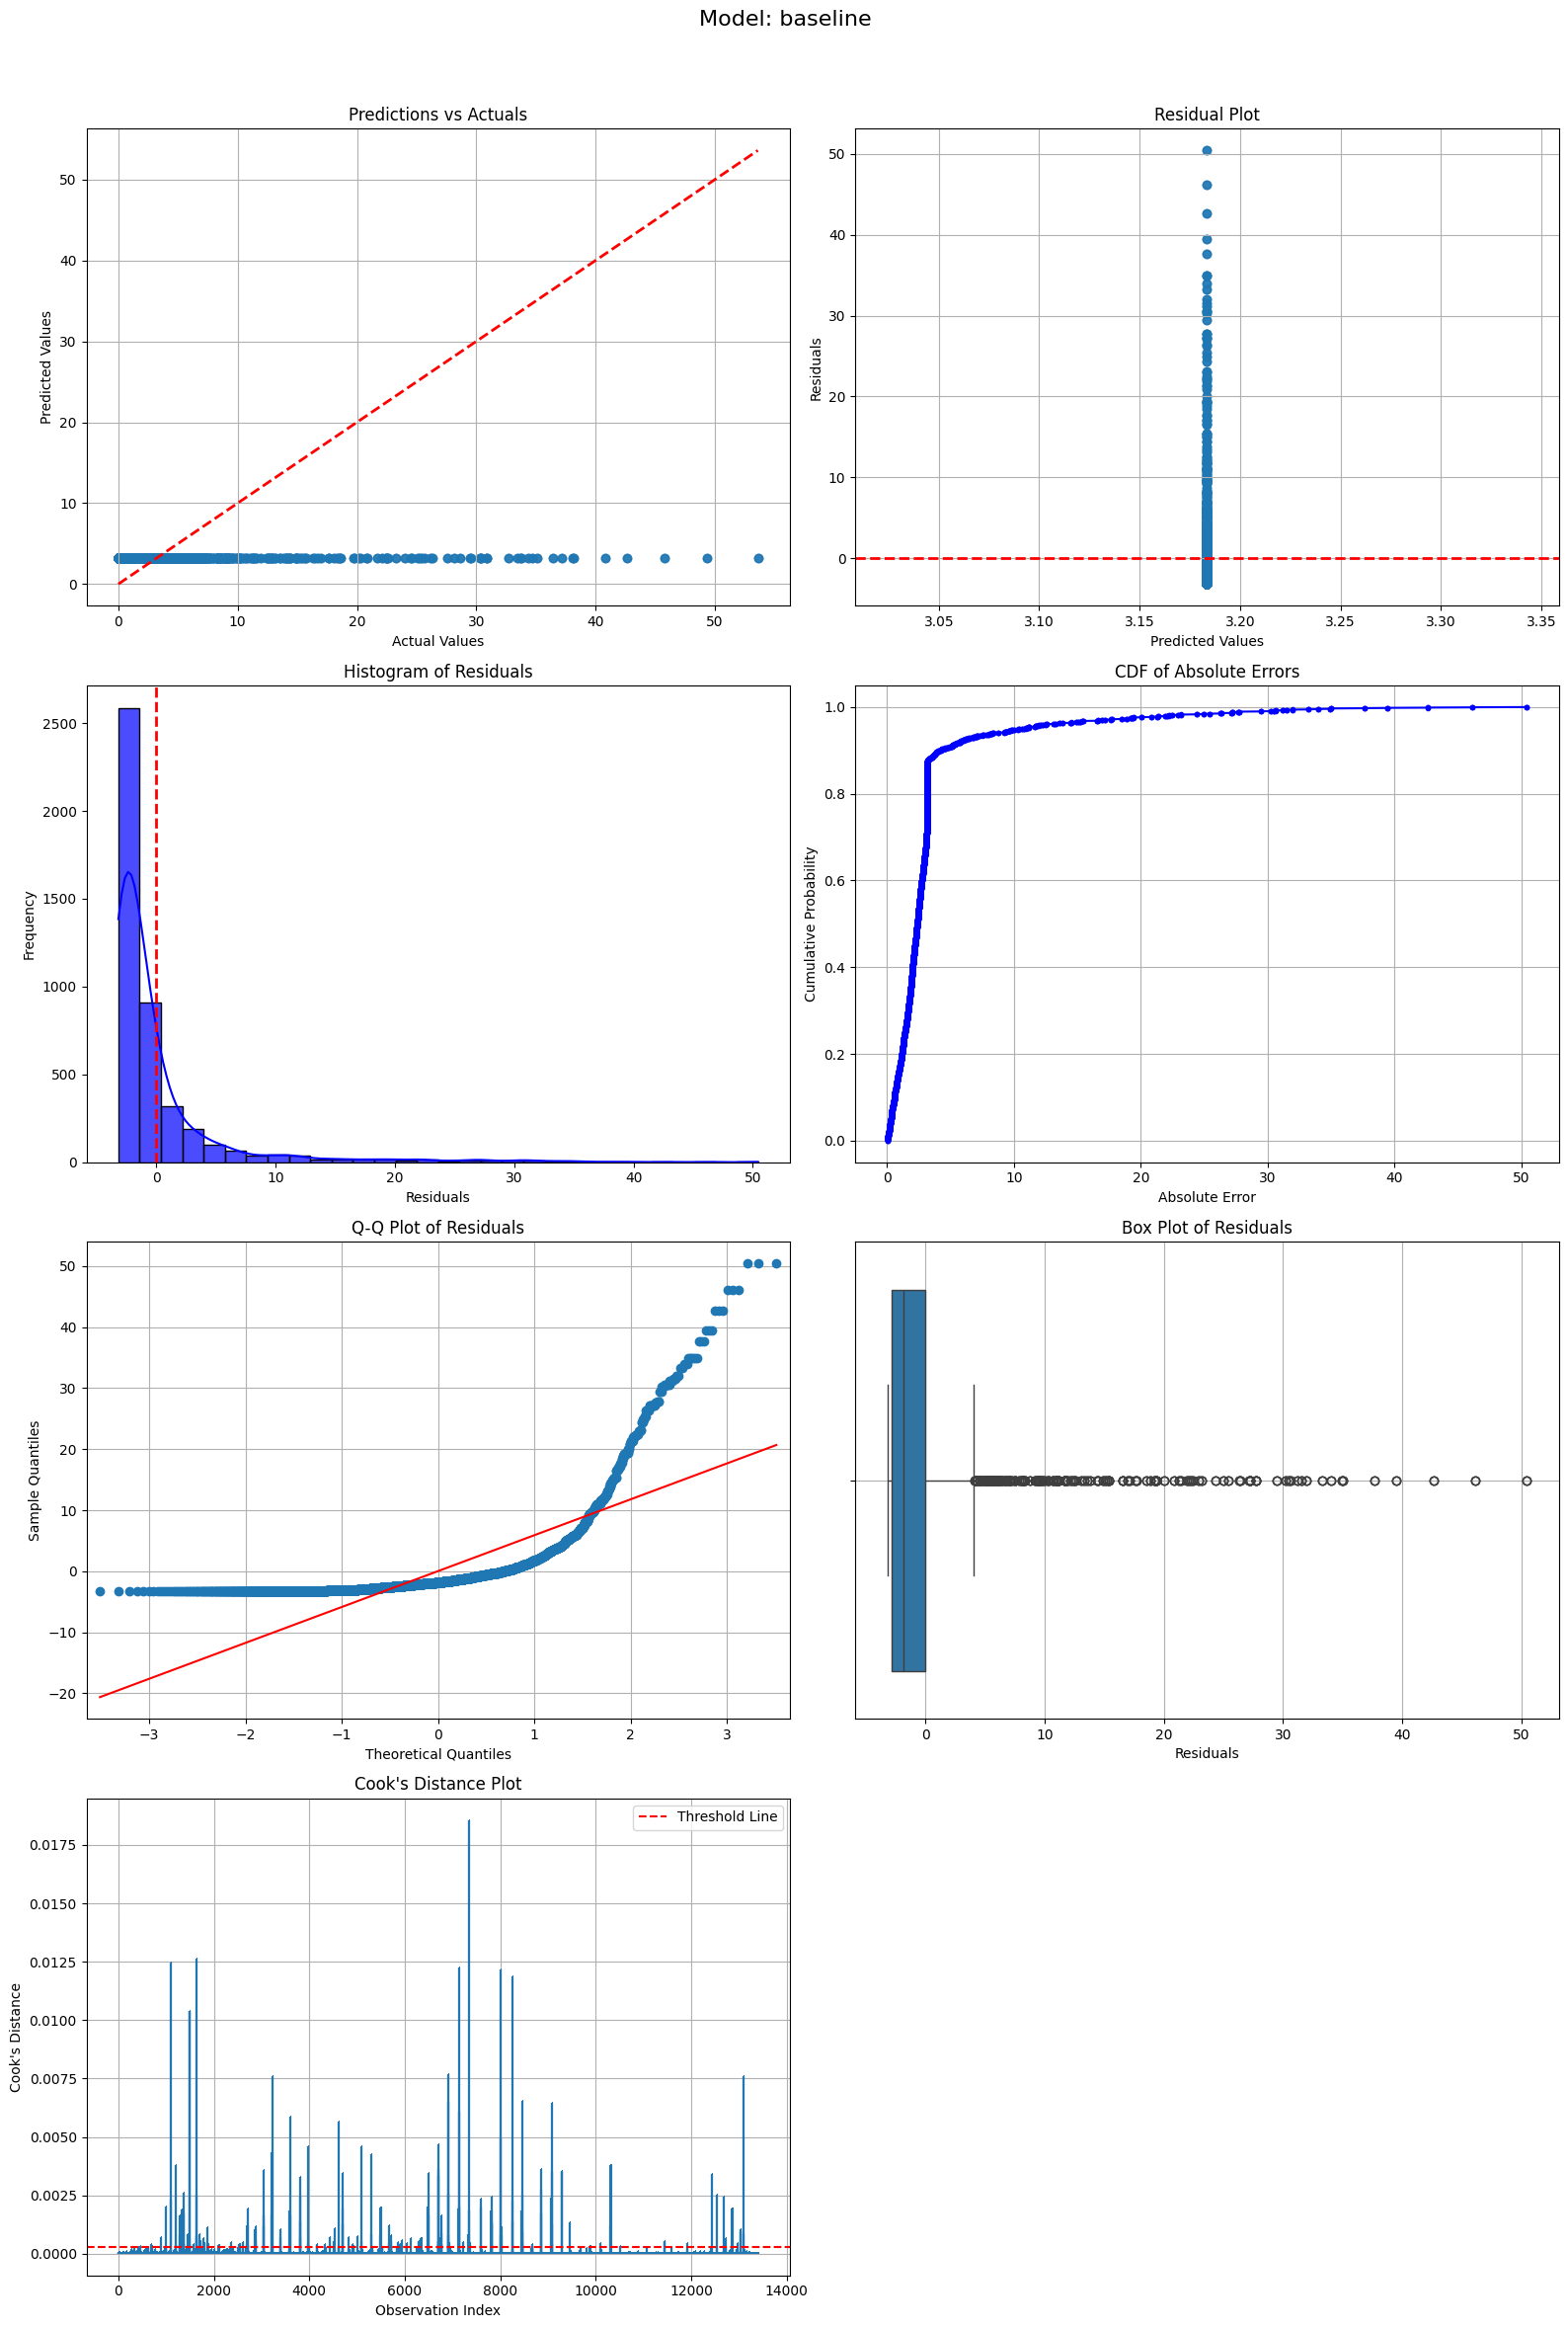

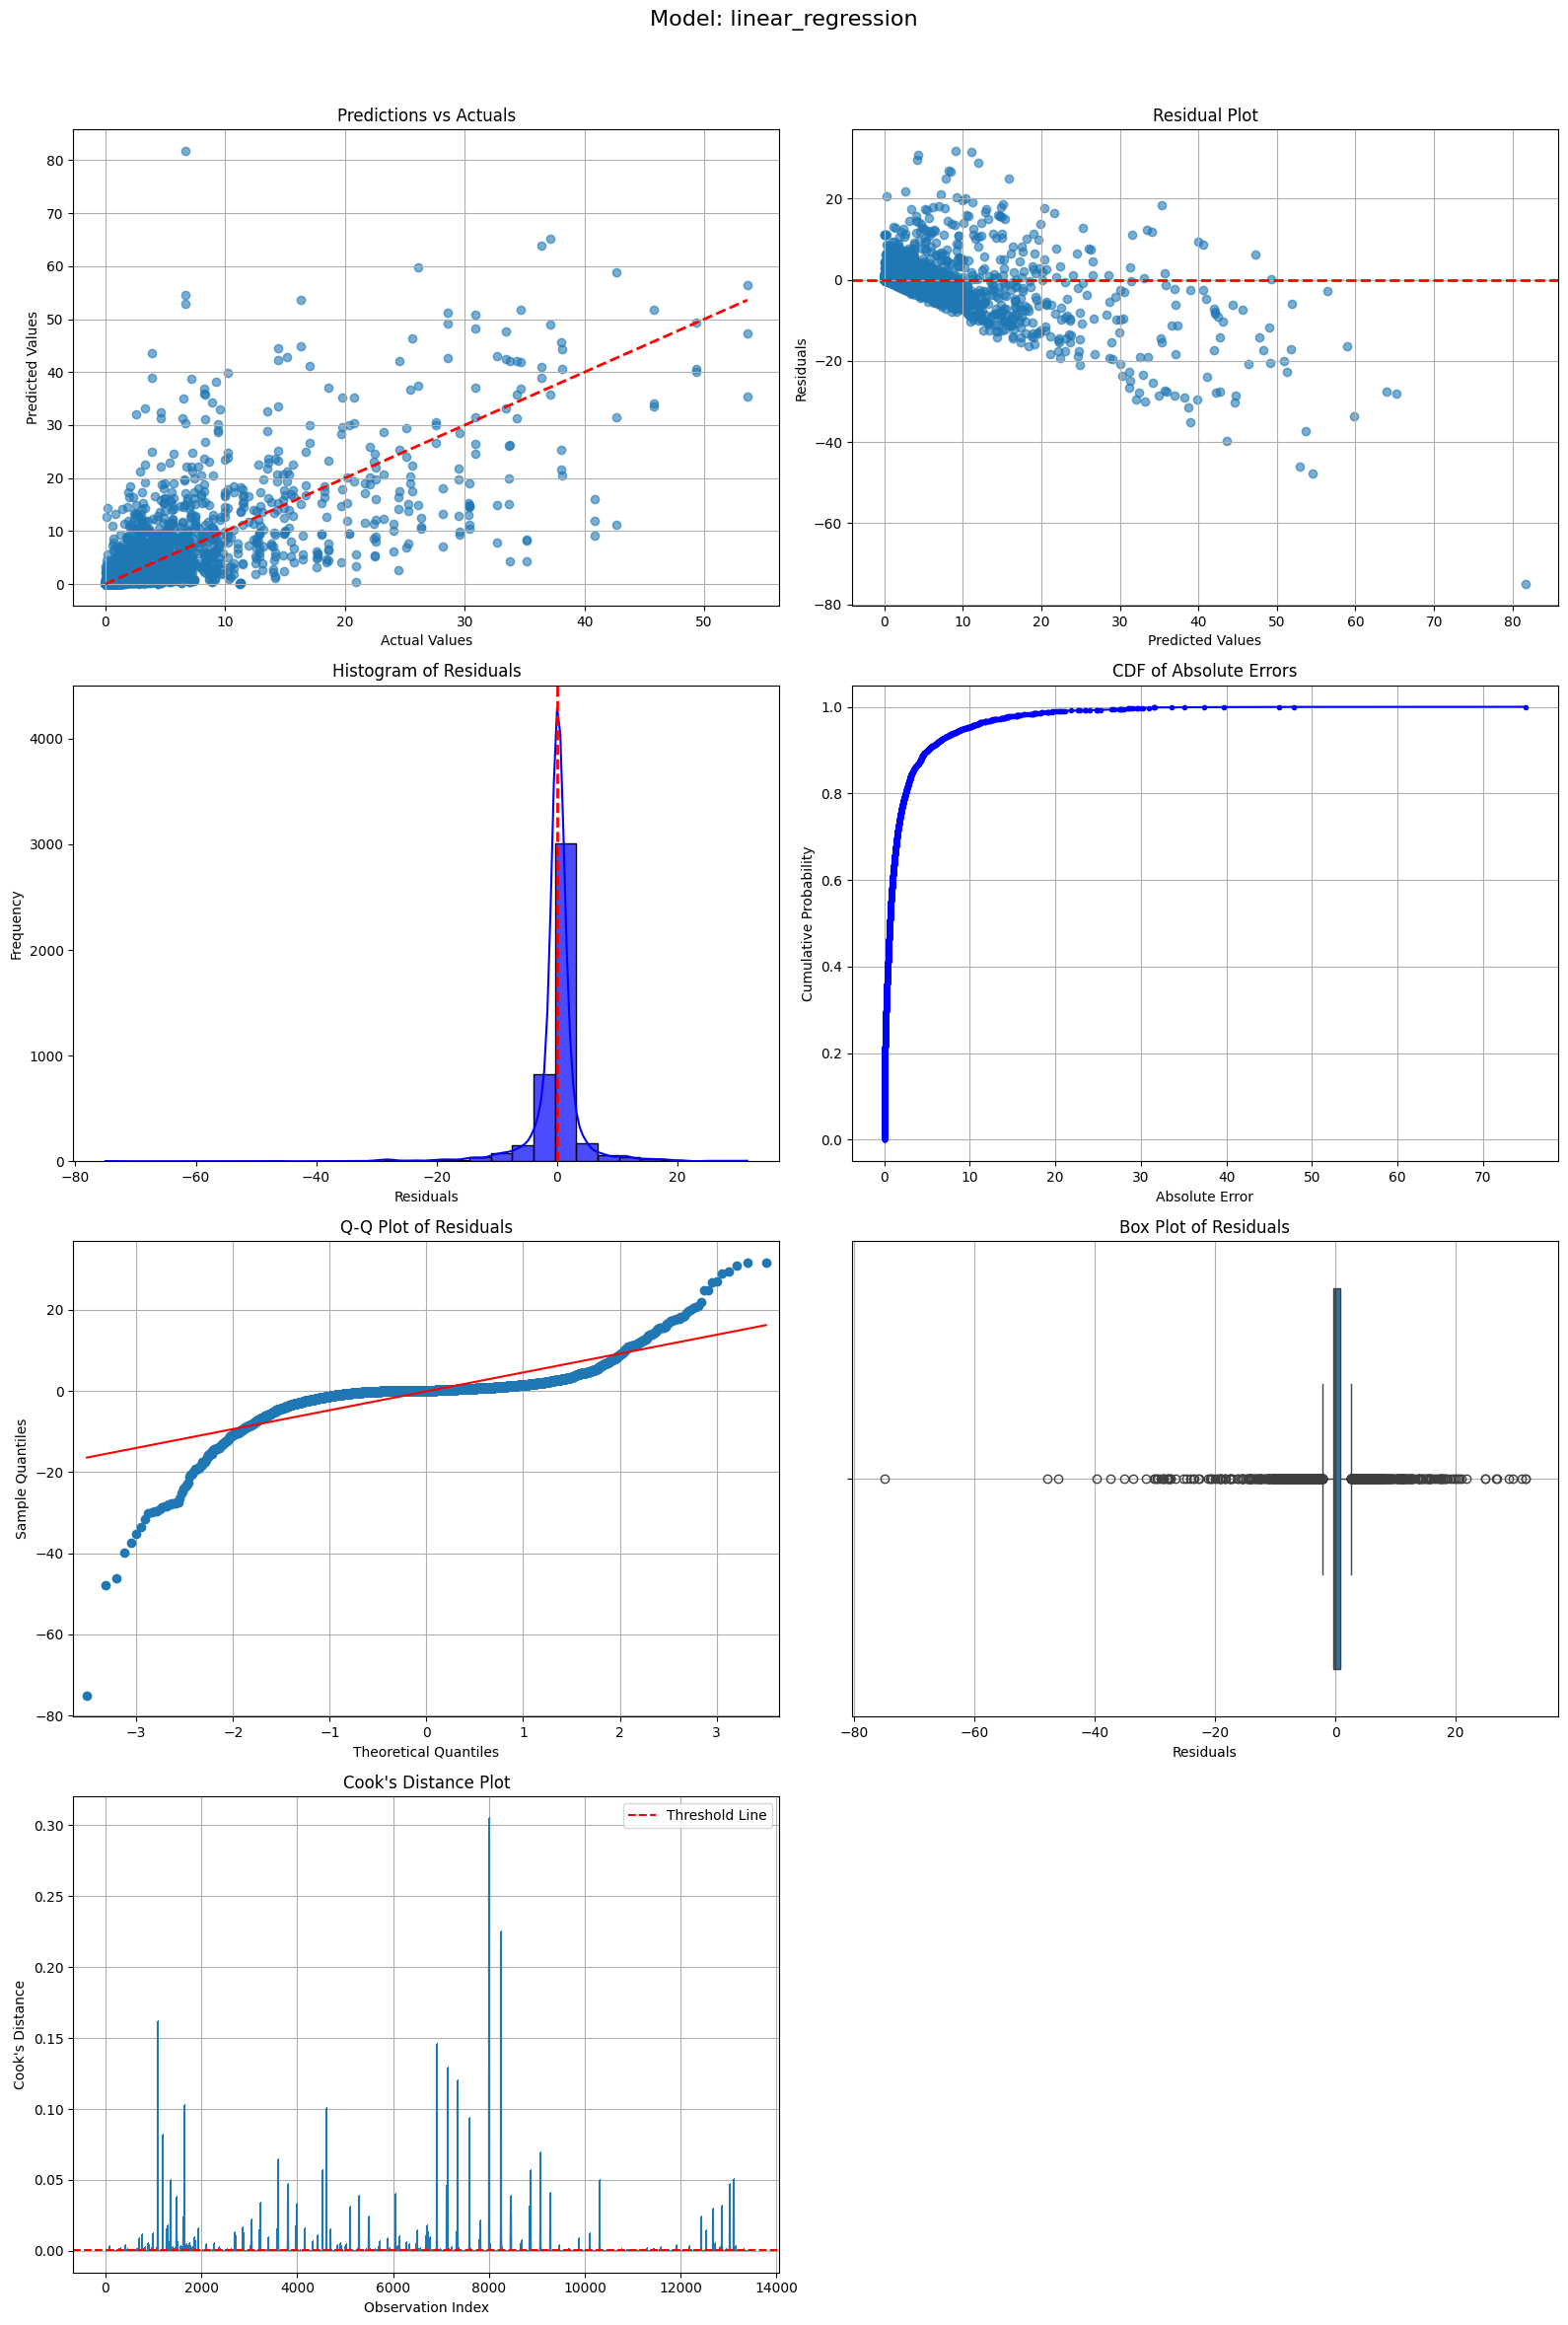

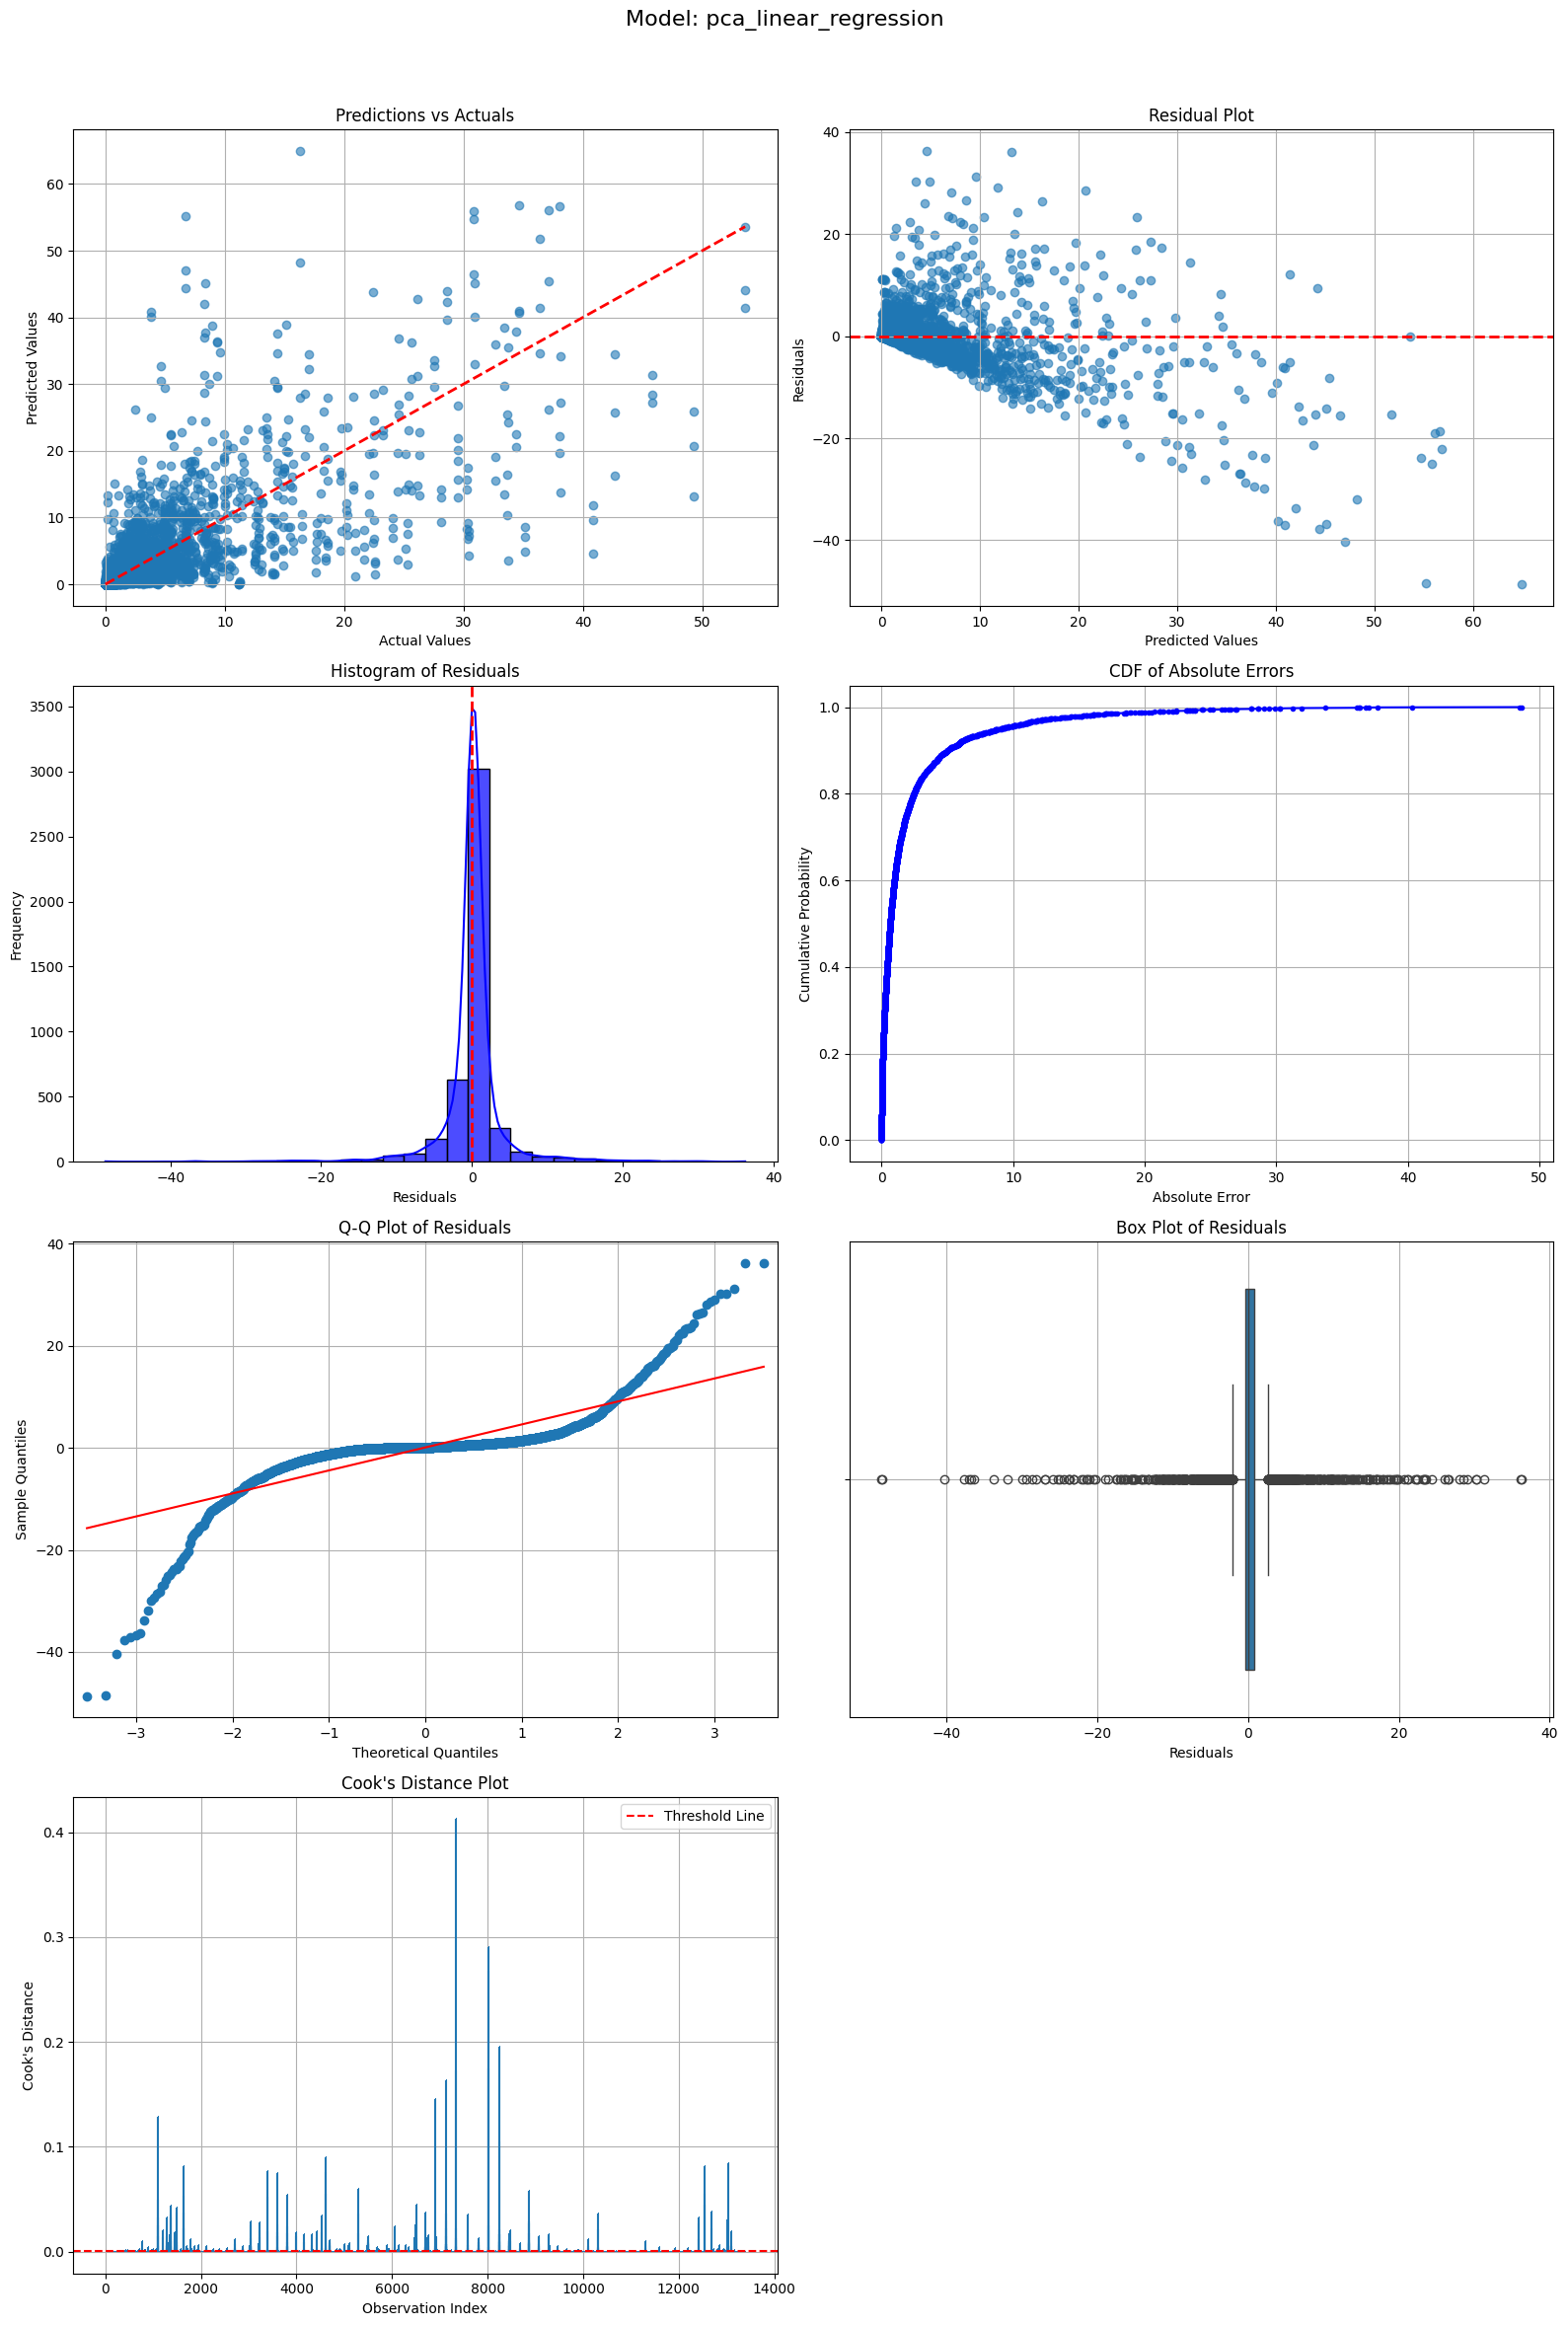

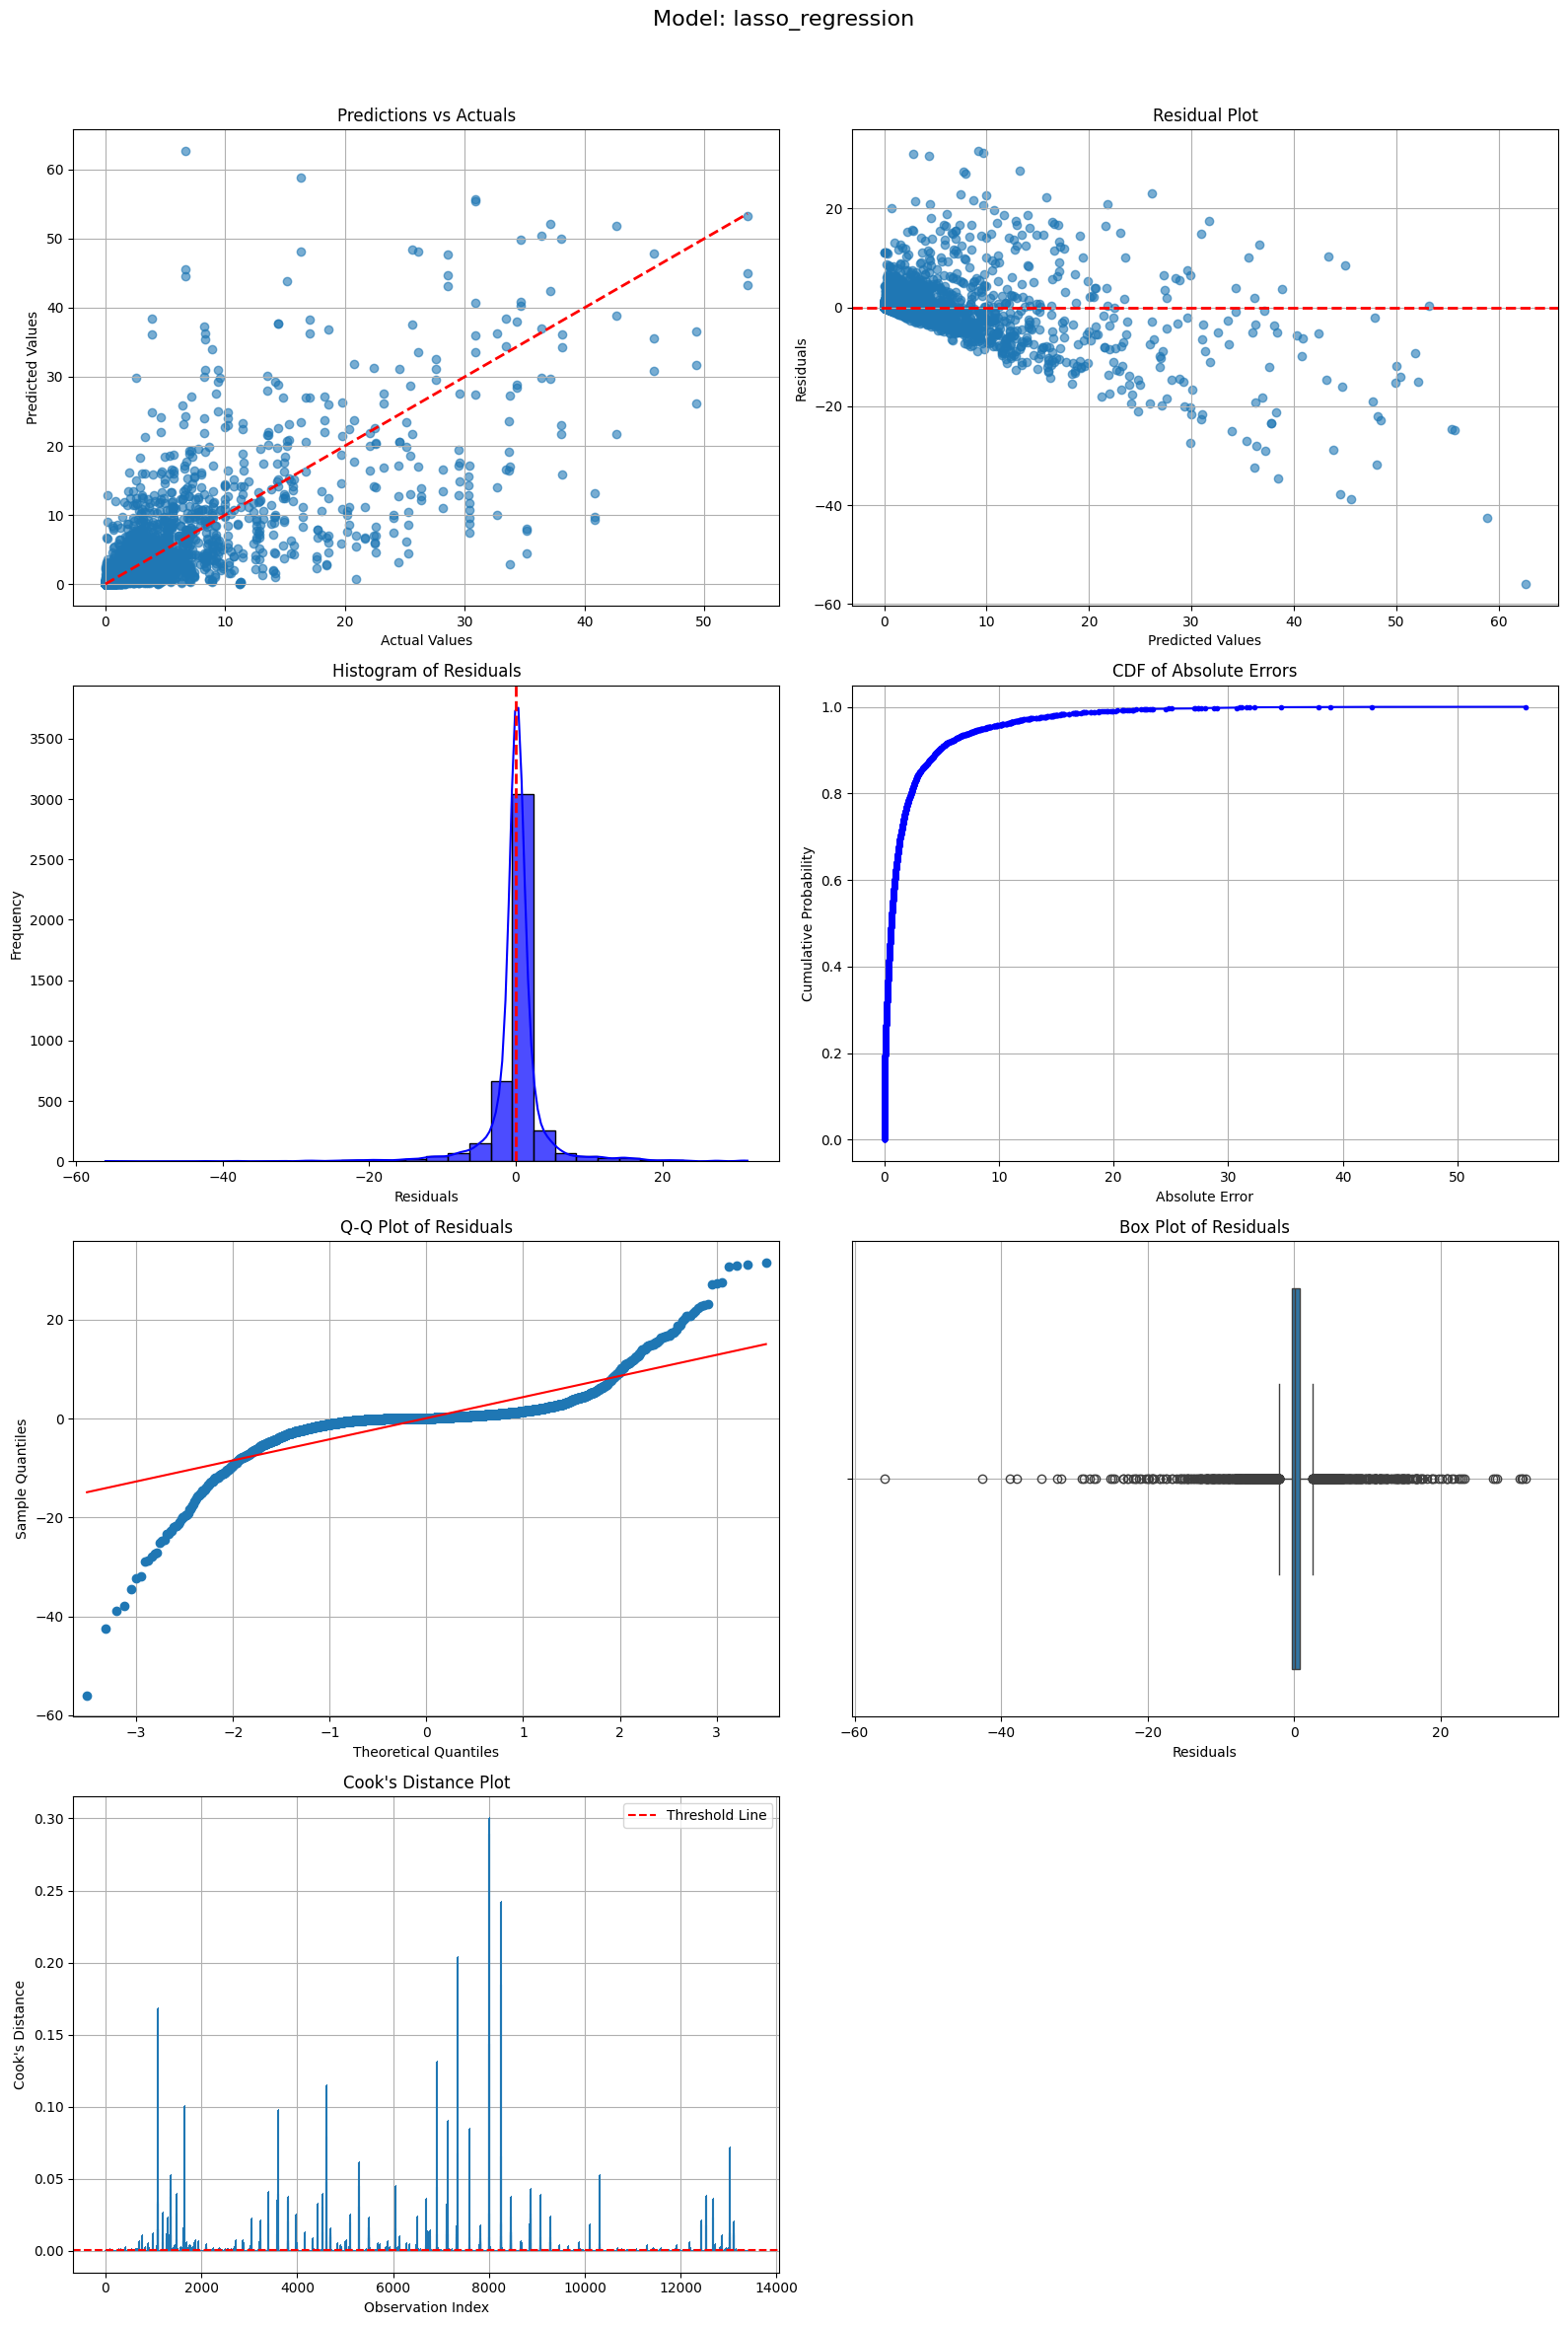

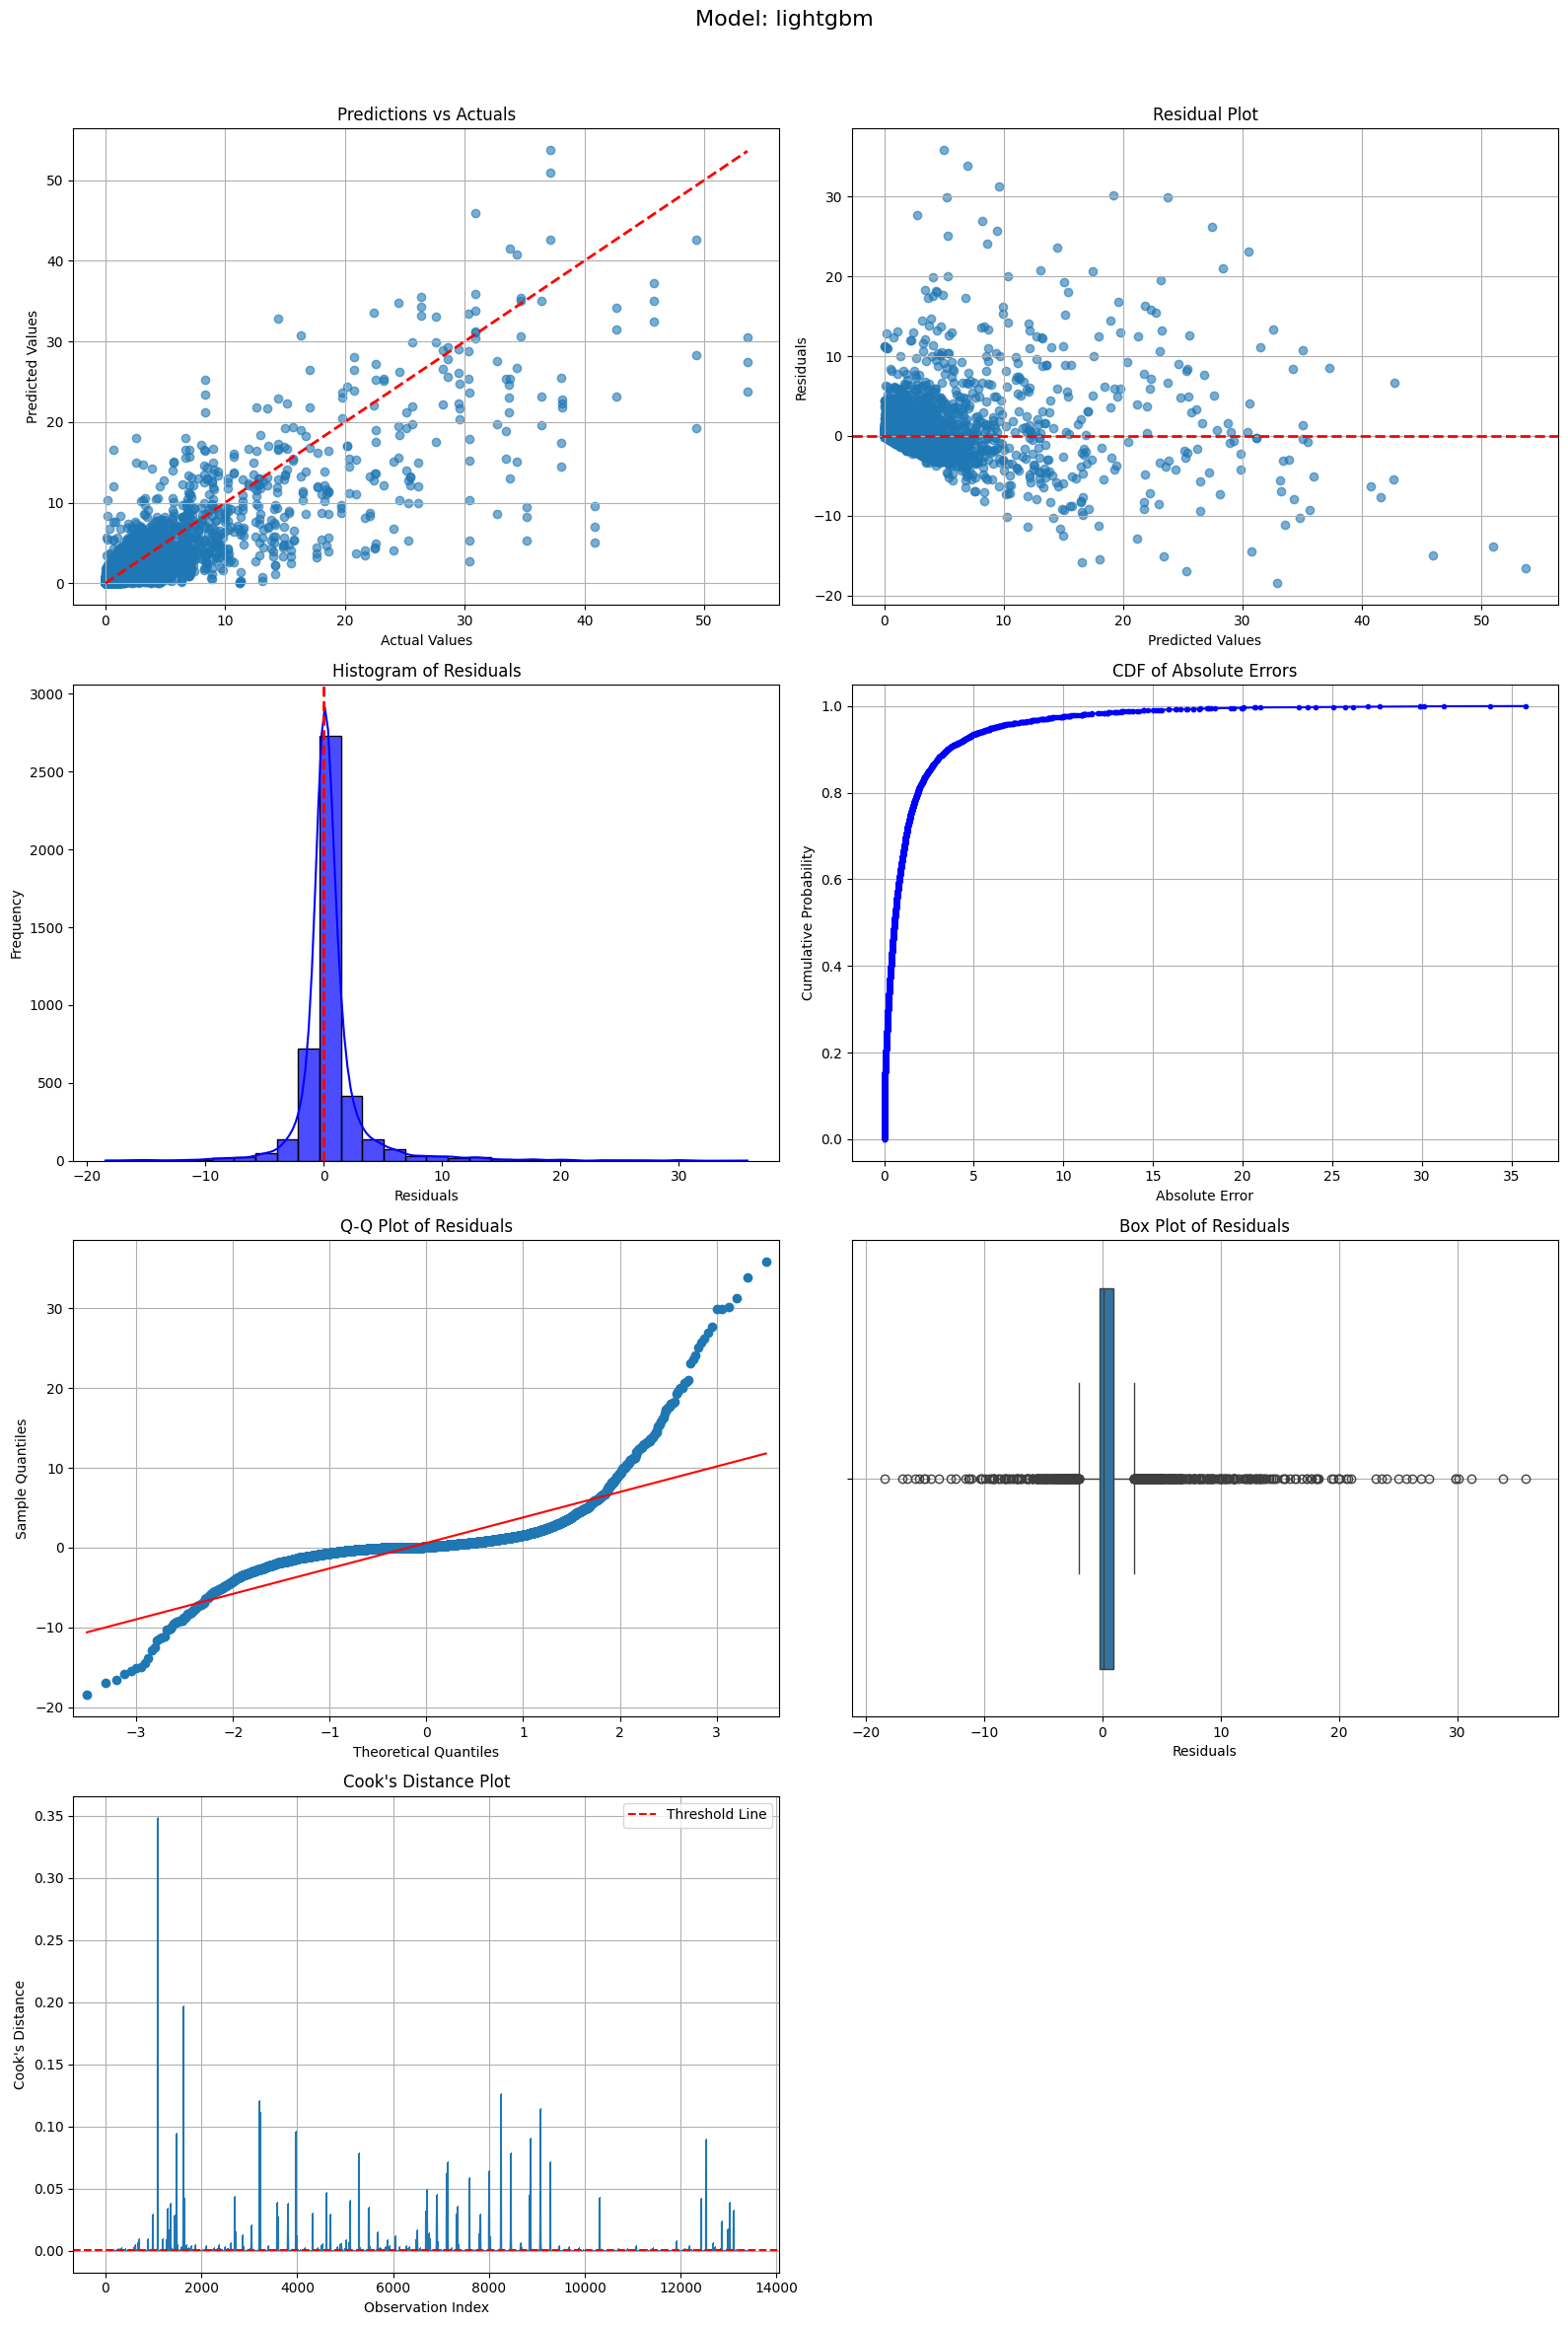

In [149]:
# Faceted plots for all models
for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = sigmoid_fun(model.predict(X_test_pca), scaler=1/100, epsilon=10e-6)
        y_pred_train = sigmoid_fun(model.predict(X_train_pca), scaler=1/100, epsilon=10e-6)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean(), dtype=np.float64)
        y_pred_train = np.full_like(y_train, y_train.mean(), dtype=np.float64)
    else:
        y_pred = sigmoid_fun(model.predict(X_test), scaler=1/100, epsilon=10e-6)
        y_pred_train = sigmoid_fun(model.predict(X_train), scaler=1/100, epsilon=10e-6)
        # if y_pred.ndim == 1:  
        #     y_pred = y_pred.reshape(-1, 1)
        # if y_pred_train.ndim == 1:
        #     y_pred_train = y_pred_train.reshape(-1, 1)

    # Define figure and axes for subplots (4 rows x 2 columns for 7 plots + title)
    fig, axs = plt.subplots(4, 2, figsize=(16, 24)) 
    fig.suptitle(f"Model: {model_name}", fontsize=16)
    
    # List of plot functions and titles
    plot_functions = [
        (plot_predictions_vs_actuals, "Predictions vs Actuals"),
        (plot_residuals, "Residual Plot"),
        (plot_residual_histogram, "Histogram of Residuals"),
        (plot_cdf_of_absolute_errors, "CDF of Absolute Errors"),
        (plot_qq_plot, "Q-Q Plot of Residuals"),
        (plot_residuals_boxplot, "Box Plot of Residuals"),
        (plot_cooks_distance, "Cook's Distance Plot")
    ]
    
    # Generate each plot directly in the subplot
    for i, (plot_func, title) in enumerate(plot_functions):
        row, col = divmod(i, 2)  # Determine subplot position
        ax = axs[row, col]
        if title != "Cook's Distance Plot":
            plot_func(y_test, y_pred, title=title, ax=ax) 
        else:
            # Cook's Distance is a measure of the influence of points on the model,
            # so it is calculated with the training data, not the test data.
            plot_func(y_train, y_pred_train, title=title, ax=ax) 

    # Remove the last empty subplot if fewer than 8 plots
    if len(plot_functions) < 8:
        fig.delaxes(axs[3, 1])  # Remove the last (4th row, 2nd column) plot
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout and title spacing
    plt.show()


In [150]:
# Generate a summary DataFrame with all metrics
metrics_summary = {
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'R^2': [],
    'sMAPE': []
}

for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = sigmoid_fun(model.predict(X_test_pca), scaler=1/100, epsilon=10e-6)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean(), dtype=np.float64)
    else:
        y_pred = sigmoid_fun(model.predict(X_test), scaler=1/100, epsilon=10e-6)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    smape_value = smape(y_test.values.ravel(), y_pred)

    metrics_summary['Model'].append(model_name)
    metrics_summary['RMSE'].append(rmse)
    metrics_summary['MAE'].append(mae)
    metrics_summary['R^2'].append(r2)
    metrics_summary['sMAPE'].append(smape_value)

# Create a DataFrame for summary
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)


                   Model      RMSE       MAE       R^2       sMAPE
0               baseline  5.884237  3.268430 -0.000032  105.104356
1      linear_regression  4.650998  2.044839  0.375222   91.632256
2  pca_linear_regression  4.506920  1.997974  0.413331   90.583590
3       lasso_regression  4.269319  1.905427  0.473558   89.311042
4               lightgbm  3.246434  1.493439  0.695599   84.428034


### Model Comparison and Selection

Based on the evaluation metrics computed for each model, we can assess the performance and make an informed decision on the most suitable model. Here’s a summary of each metric and its interpretation:

| Metric | Description | Best Model (Value) | Interpretation |
|--------|-------------|--------------------|----------------|
| **RMSE** | Root Mean Squared Error (sensitive to large errors) | Lasso Regression (2.5538) | Lower RMSE indicates better performance, penalizing larger deviations more. Lasso Regression achieves the lowest RMSE, meaning it has fewer large errors. |
| **MAE** | Mean Absolute Error (average magnitude of errors) | LightGBM (1.3936) | Lower MAE indicates smaller average errors. LightGBM has the lowest MAE, suggesting it performs best in terms of overall accuracy on average. |
| **R²** | Proportion of variance explained by the model | Lasso Regression (0.8019) | Higher R² indicates that the model explains more variance in the data. Lasso Regression explains about 80.19% of the target variance, the highest among all models. |
| **sMAPE** | Symmetric Mean Absolute Percentage Error (percentage error measure) | LightGBM (80.24) | Lower sMAPE indicates that predictions are closer to actual values relative to their size. LightGBM performs best on this metric, showing relatively smaller percentage errors. |

### Model Selection Based on Metric Prioritization

#### 1. **If minimizing large errors is critical**:
   - **Lasso Regression** is the best choice due to its lowest RMSE and highest R², making it more sensitive to large deviations and better at explaining variance.

#### 2. **If overall accuracy (average error) is the primary goal**:
   - **LightGBM** is preferred, given its lowest MAE and lowest sMAPE, indicating it makes smaller errors on average and performs better when considering percentage errors.

#### 3. **If interpretability is important**:
   - Linear models, such as **Lasso Regression** and **Linear Regression**, offer more interpretability compared to **LightGBM**.
   - **Lasso Regression** provides a balance between interpretability and performance.

### Recommendation

- **If interpretability and model simplicity are less important**: Choose **LightGBM** for its strong performance across MAE and sMAPE. It provides a good balance across metrics, especially for minimizing average error.
  
- **If interpretability and understanding feature impacts are key**: **Lasso Regression** is an excellent choice, providing robust performance with interpretable coefficients.

In conclusion, **LightGBM** is the recommended model if minimizing errors is the primary objective, as it balances high performance across RMSE, MAE, and sMAPE. However, for more transparent analysis and insight into feature impacts, **Lasso Regression** provides similar performance with enhanced interpretability.


In [73]:
y_test.describe()

,avg_urban_imperviousness
count,4467.000000
mean,3.134666
std,5.738279
min,0.000000
25%,0.326822
50%,1.279983
75%,3.110901
max,53.226423


### Error Analysis in Context of Target Distribution

To assess whether the error ranges (RMSE and MAE) of the best-performing models—**LightGBM** and **Lasso Regression**—are reasonable, we can compare these metrics against the distribution of the target variable in our data.

#### Interpretation of Target Distribution

- **Mean and Median**: The mean is **3.13** and the median is **1.28**, indicating that the distribution is positively skewed, with most values concentrated on the lower end.
  
- **Standard Deviation**: A standard deviation of **5.74** suggests considerable variability in the target values, implying that there are higher values that create a spread around the mean.

- **Percentiles**: With the 75th percentile at **3.11**, 75% of target values fall below this threshold, while the maximum value reaches **53.23**—indicating some high outliers that could skew the distribution.

#### Comparison with Model Error Metrics

The best models yielded the following error metrics:

| Model               | RMSE   | MAE   |
|---------------------|--------|-------|
| **LightGBM**        | 2.60   | 1.39  |
| **Lasso Regression**| 2.55   | 1.73  |

1. **RMSE Comparison**:
   - The RMSE values (around **2.55 to 2.60**) are reasonable given the target’s variability, especially as they are below the standard deviation (**5.74**) of the target variable. This suggests the models handle larger errors effectively, even with the presence of high outliers.
   
2. **MAE Comparison**:
   - The MAE values (between **1.39 and 1.73**) indicate that the average absolute error is close to the median value of **1.28**, suggesting that typical prediction errors are proportionate to the typical values in the data.
   - **LightGBM**, with an MAE of **1.39**, shows particularly good performance in minimizing average error.

3. **Outliers and Error Sensitivity**:
   - The maximum value of the target variable (**53.23**) is significantly higher than most other values, and errors for these extreme cases can inflate RMSE. Despite this, both models keep RMSE and MAE within a reasonable range, suggesting robust performance even with some outliers.

#### Conclusion

The error metrics for **LightGBM** and **Lasso Regression** are reasonable in the context of the target variable’s distribution:

- **LightGBM** has a slightly better MAE, indicating stronger performance in minimizing average errors across typical values.
- **Lasso Regression** achieves a marginally lower RMSE, suggesting it may handle outliers somewhat better.

In summary, both models exhibit error metrics that are proportionate to the distribution of the target variable, with **LightGBM** and **Lasso Regression** providing effective performance across typical values and outliers. This makes them both strong candidates for the task, depending on whether average accuracy (MAE) or outlier sensitivity (RMSE) is prioritized.
